#### import libraries

In [ ]:
%pip install seaborn 

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement imblearn.over_sampling (from versions: none)

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for imblearn.over_sampling


In [10]:
%pip install imbalanced-learn


  Using cached imbalanced_learn-0.14.0-py3-none-any.whl.metadata (8.8 kB)
Using cached imbalanced_learn-0.14.0-py3-none-any.whl (239 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit
from sklearn.preprocessing import LabelEncoder, RobustScaler
# enable experimental iterative imputer API before importing IterativeImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve)
from imblearn.over_sampling import SMOTENC

Load and Prepare the Dataset

In [12]:
df = pd.read_csv('factory_data (classification).csv')
df

,Unique ID,Product ID,Quality,Ambient T (C),Process T (C),Rotation Speed (rpm),Torque (Nm),Tool Wear (min),Machine Status
0,1,K12965,M,24.95,35.45,1551.0,42.8,0,0
1,2,Z62710,L,25.05,35.55,1408.0,46.3,3,0
2,3,T20224,L,24.95,35.35,1498.0,49.4,5,0
3,4,Z33024,L,25.05,35.45,1433.0,39.5,7,0
4,5,Z52839,L,25.05,35.55,1408.0,40.0,9,0
...,...,...,...,...,...,...,...,...,...
19995,19996,T87335,M,25.75,35.35,NaN,29.5,14,0
19996,19997,Z59525,H,25.85,35.35,1632.0,31.8,17,0
19997,19998,T83921,M,25.95,NaN,NaN,33.4,22,0
19998,19999,K42424,H,25.95,35.65,1408.0,48.5,25,0


In [13]:
df = df.drop(['Unique ID'], axis=1)

In [14]:
df.rename(columns={'Tool Wear (min)': 'Tool Lifespan (min)'}, inplace=True)

Drop rows with zeroes in key numeric columns

In [15]:
df = df.loc[
    (df[['Ambient T (C)', 'Process T (C)', 'Rotation Speed (rpm)', 'Torque (Nm)', 'Tool Lifespan (min)']] != 0).all(axis=1)
]

Simplify Product ID to first letter

In [16]:
df['Product Code'] = df['Product ID'].astype(str).str[0]
df = df.drop(['Product ID'], axis=1)

Split dataset into train and test 

In [17]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

Feature Engineering

In [18]:
for data in [train, test]:
    data['T Difference Squared (C^2)'] = (data['Ambient T (C)'] - data['Process T (C)']) ** 2
    data['Tool Lifespan/Temp Increase^2 (min/C^2)'] = (
        data['Tool Lifespan (min)'] / data['T Difference Squared (C^2)']
    ).round(2)
    data['Horsepower (HP)'] = (data['Rotation Speed (rpm)'] * data['Torque (Nm)']) / 5252

### Data Cleaning and Imputation

Separate categorical and numerical data

In [19]:
cat_cols = ['Quality', 'Product Code', 'Machine Status']
num_cols = [c for c in train.columns if c not in cat_cols]

Impute categorical data (most frequent)

In [20]:
cat_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'))
categorical_df = pd.DataFrame(cat_pipe.fit_transform(train[cat_cols]), columns=cat_cols)

Impute numerical data (Iterative + RobustScaler)

In [21]:
num_pipe = make_pipeline(RobustScaler(), IterativeImputer(random_state=42))
numerical_df = pd.DataFrame(num_pipe.fit_transform(train[num_cols]), columns=num_cols)

c:\Users\Deep\Downloads\3 projects\.venv\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Combine again

In [22]:
train_cleaned = pd.concat([numerical_df, categorical_df], axis=1)

Repeat for test

In [23]:
categorical_df_test = pd.DataFrame(cat_pipe.transform(test[cat_cols]), columns=cat_cols)
numerical_df_test = pd.DataFrame(num_pipe.transform(test[num_cols]), columns=num_cols)
test_cleaned = pd.concat([numerical_df_test, categorical_df_test], axis=1)

Encode Categorical Columns

In [24]:
le = LabelEncoder()
for col in ['Quality', 'Product Code']:
    train_cleaned[col] = le.fit_transform(train_cleaned[col])
    test_cleaned[col] = le.transform(test_cleaned[col])

train_cleaned['Machine Status'] = train_cleaned['Machine Status'].astype(int)
test_cleaned['Machine Status'] = test_cleaned['Machine Status'].astype(int)

Handle Class Imbalance (SMOTENC)

In [25]:
X = train_cleaned.drop('Machine Status', axis=1)
y = train_cleaned['Machine Status']

sm = SMOTENC(random_state=42, categorical_features=[0, 1])
X_res, y_res = sm.fit_resample(X, y)

Train-Test Split

In [27]:
# After SMOTE-NC oversampling
X_res, y_res = sm.fit_resample(X, y)

# Assign train-test splits properly
X_train, y_train = X_res, y_res
X_test = test_cleaned.drop('Machine Status', axis=1)
y_test = test_cleaned['Machine Status']


K-Nearest Neighbors

In [28]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
y_prob_knn = knn.predict_proba(X_test)[:, 1]

Evaluation Metrics

In [38]:
print(classification_report(y_test, y_pred_knn, target_names=['Working', 'Broken']))

              precision    recall  f1-score   support

     Working       0.99      0.95      0.97      3804
      Broken       0.38      0.77      0.51       148

    accuracy                           0.94      3952
   macro avg       0.68      0.86      0.74      3952
weighted avg       0.97      0.94      0.95      3952



Confusion Matrix

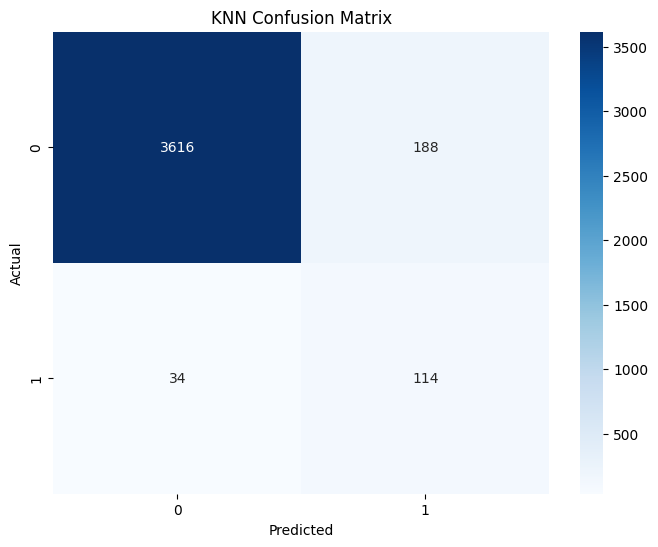

In [30]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("KNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

ROC Curve

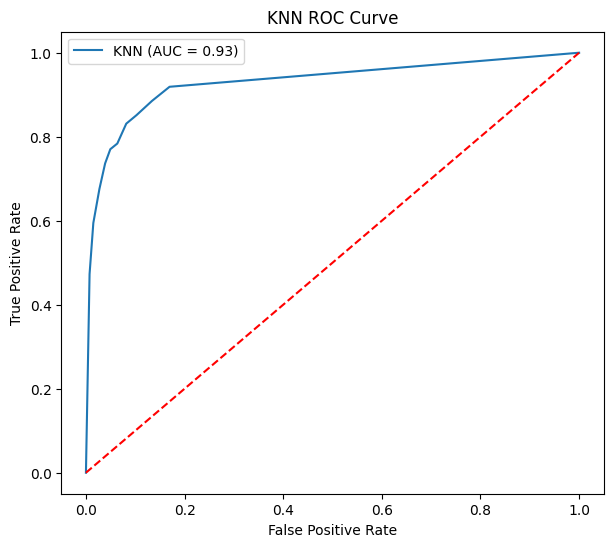

In [31]:
fpr, tpr, _ = roc_curve(y_test, y_prob_knn)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f'KNN (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'r--')
plt.legend()
plt.title('KNN ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

Precision-Recall Curve

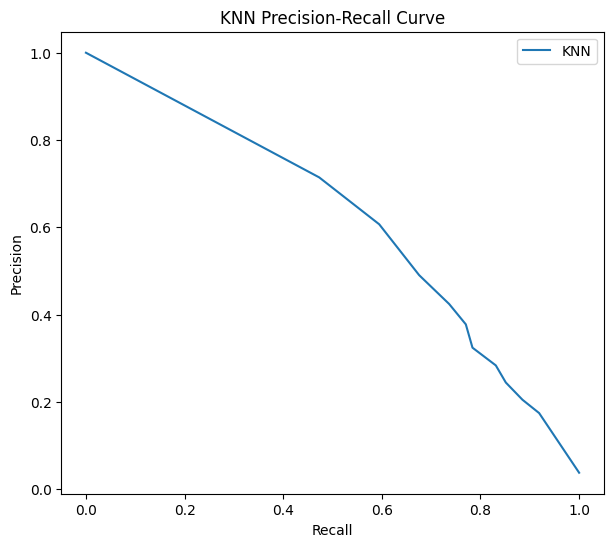

In [32]:
precision, recall, _ = precision_recall_curve(y_test, y_prob_knn)
plt.figure(figsize=(7, 6))
plt.plot(recall, precision, label='KNN')
plt.title('KNN Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

Gaussian Naive Bayes

In [37]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
y_prob_nb = nb.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_nb, target_names=['Working', 'Broken']))

              precision    recall  f1-score   support

     Working       0.99      0.84      0.91      3804
      Broken       0.17      0.85      0.28       148

    accuracy                           0.84      3952
   macro avg       0.58      0.84      0.59      3952
weighted avg       0.96      0.84      0.88      3952



Confusion Matrix

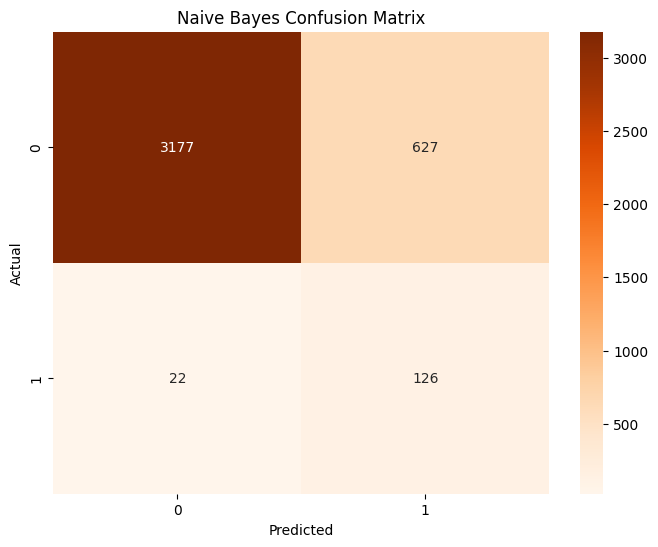

In [34]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
plt.title("Naive Bayes Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

ROC Curve

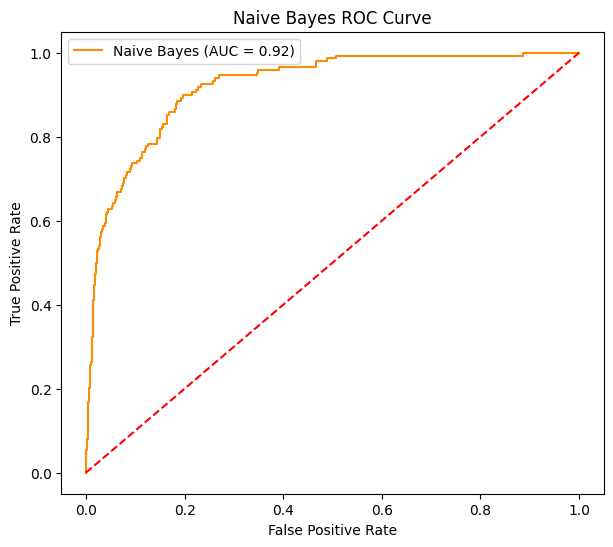

In [35]:
fpr, tpr, _ = roc_curve(y_test, y_prob_nb)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f'Naive Bayes (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'r--')
plt.legend()
plt.title('Naive Bayes ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

Precision-Recall Curve

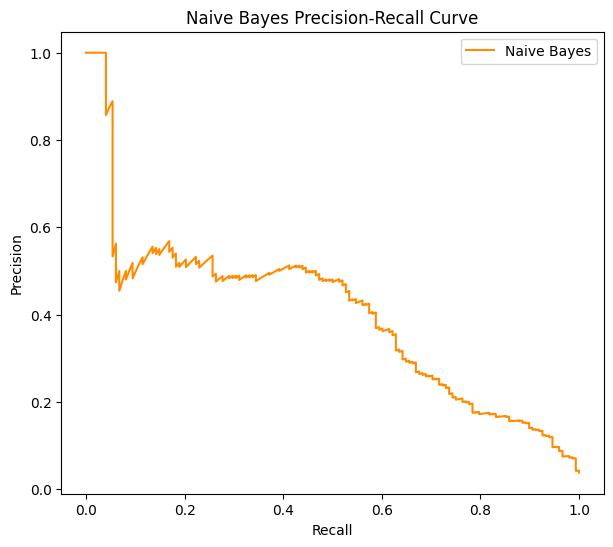

In [36]:
precision, recall, _ = precision_recall_curve(y_test, y_prob_nb)
plt.figure(figsize=(7, 6))
plt.plot(recall, precision, label='Naive Bayes', color='darkorange')
plt.title('Naive Bayes Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()